# Исследование воронки продаж продуктов питания

**Цель проекта:**
Изучить воронку продаж, проанализировать результаты A/A/B теста и вернуться с рекомендациями

**План исследования:**

1. Загрузить все необходимые библиотеки

2. Переименовать наименование столбцов и изменить тип данных, а также добавить отдельный столбец дат

3. Проверить на пропуски и дубликаты, при необходимости удалить строки, удаления которых не повлияет на итоговый результат

4. Проверить на аномальные значения

5. Проверить группы на наличие клиента в двух и более группах одновременно и на соотношение кол-ва клиентов в группах

6. Изучить и проверить данные

7. Изучить воронку событий

8. Проанализировать результаты тестирования и описать выводы/рекомендации

**Описания контекста:**

1. Переименовала наименование столбцов, добавила столбец дат для использования в дальнейшей аналитике, проверила на пропуски методом info, удалила явные дубликаты, проверила на аномальные/отрицательные/нулевые значения методом describe (не выявлено), а также проверила соотношение кол-ва клиентов между группами (незначительные отклонения) и на наличие клиентов в двух и более группах одновременно (отсутствуют)

2. Определила горизонт анализа и изучила изменения в данных после отсечения по горизонту (незначительное влияние)

3. Проанализировала воронку событий и определила узкие места (страницы, на которые нужно обратить внимание)

4. Изучила результаты эксперимента с помощью Z-теста - отдельно проверила группа 246/247 на статистические различия, далее сравнила группы 246/248, 247/248 и 246+247/248. Основа сравнения: доля уникальных пользователей каждой группы с учетом конкретного event от общего числа уникальных пользователей в каждой группе

5. Описала выводы/факты и узкие места/рекоменадции

**Шаг 1. Откройте файл с данными и изучите общую информацию**

In [1]:
%pip install -U kaleido -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
#загрузила все необходимые библиотеки
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import math as mth
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

In [3]:
#загрузила датафрейм
data=pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


**Шаг 2. Подготовьте данные**

In [4]:
#переименовала наименование столбцов
data.columns=['event_name', 'user_id', 'event_dt', 'group']
data.head(10)

,event_name,user_id,event_dt,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [5]:
#изменила тип данных и добавила поле c датами
data['event_dt']=pd.to_datetime(data['event_dt'], unit='s')
data['dt']=data['event_dt'].dt.date
data.head(10)

,event_name,user_id,event_dt,group,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [6]:
#проверила на пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_dt    244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   dt          244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


**Вывод: метод info показал, что пропусков нет**

In [7]:
#проверила на дубликаты
data.duplicated().sum()

413

In [8]:
#посчитала долю дубликатов
print('Доля дубликатов:', round((data.duplicated().sum()/data['event_name'].count())*100, 2,), '%')

Доля дубликатов: 0.17 %


**Вывод: 413 явных дубликатов, которые составяют менее 1% (0,17%), необходимо удалить**

In [9]:
#посмотрела на дубликаты
data[data.duplicated()].head(10)

,event_name,user_id,event_dt,group,dt
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01
5641,CartScreenAppear,4248762472840564256,2019-08-01 05:36:04,248,2019-08-01
5875,PaymentScreenSuccessful,6427012997733591237,2019-08-01 05:47:32,248,2019-08-01
7249,OffersScreenAppear,7224691986599895551,2019-08-01 06:44:06,246,2019-08-01
8065,CartScreenAppear,8189122927585332969,2019-08-01 07:18:49,248,2019-08-01
9179,MainScreenAppear,2230705996155527339,2019-08-01 07:54:47,246,2019-08-01


In [10]:
#удалила дубликаты и сохранила обновленный датафрейм в переменную df
df=data.drop_duplicates().reset_index(drop=True)

In [11]:
df.duplicated().sum()

0

**Вывод: дубликатов больше нет**

In [12]:
#проверила на аномальные/нулевые/отрицательные значения
df.describe()

,user_id,group
count,2.437130e+05,243713.000000
mean,4.627963e+18,247.022161
std,2.642723e+18,0.824420
min,6.888747e+15,246.000000
25%,2.372212e+18,246.000000
50%,4.623192e+18,247.000000
75%,6.932517e+18,248.000000
max,9.222603e+18,248.000000


**Вывод: метод describe показал, что аномальных значений нет**

In [13]:
#проверила группы на наличие клиента в двух и более группах одновременно и на соотношение кол-ва клиентов в группах
df.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2489
247,2520
248,2542


In [14]:
df['user_id'].nunique()

7551

In [15]:
df_duplicate=(
    df.groupby('user_id')
    .agg({'group':'nunique'})
    .sort_values(by='group', ascending=False)
)
df_duplicate

,group
user_id,
6888746892508752,1
6207768971558512760,1
6217807653094995999,1
6217295124800833842,1
6216080220799726690,1
...,...
3175239243679501019,1
3171891164497446149,1
3171454373076660766,1


**Вывод: разница в соотношении приемлема, задублированных клиентов нет (проверила путем сложения пользователей всех групп и сравнила с общим числом уникальных пользователей, а также сгруппировала по клиентам и посчитала кол-во уникальны групп - оба варианта показали отсутствие задублированных клиентов в группах)**

**Шаг 3. Изучите и проверьте данные**

In [16]:
#посчитала сколько всего событий в логе
print('Всего событий в логе:', df['event_name'].count())

Всего событий в логе: 243713


In [17]:
#посчитала сколько всего пользователей в логе
print('Всего пользователей в логе:', df['user_id'].nunique())

Всего пользователей в логе: 7551


In [18]:
#посчитала сколько в среднем событий приходится на пользователя
df_avg_user_id=(
    df.groupby('user_id')
    .agg(
        {
            'event_dt':'max',
            'event_name':'count',
        }
    )
    .sort_values(by='event_name', ascending=False)
)
df_avg_user_id

,event_dt,event_name
user_id,,
6304868067479728361,2019-08-07 19:26:48,2307
197027893265565660,2019-08-07 16:37:52,1998
4623191541214045580,2019-08-06 20:59:28,1768
6932517045703054087,2019-08-07 19:58:43,1439
1754140665440434215,2019-08-07 07:00:33,1221
...,...,...
7399061063341528729,2019-08-01 08:32:27,1
2968164493349205501,2019-08-06 14:53:04,1
8071397669512236988,2019-08-01 14:00:00,1


In [19]:
df_avg_user_id.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


**Вывод: в среднем на одного пользователя приходится 32 события, по медиане - 20, видимо значительное кол-во пользователей с аномальным кол-вом событий**

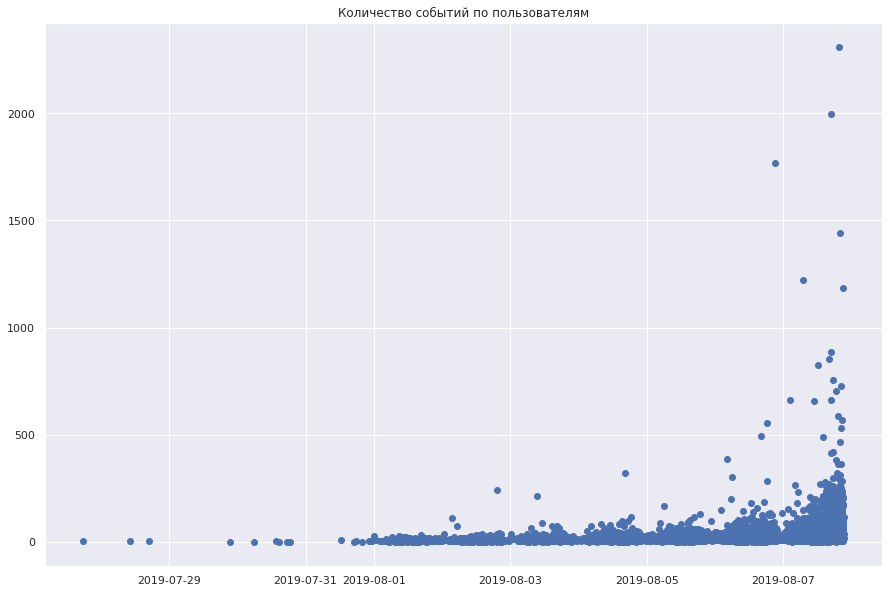

In [20]:
#построила графики для наглядности распределения событий по пользователям
plt.scatter(df_avg_user_id['event_dt'], df_avg_user_id['event_name'])
plt.title('Количество событий по пользователям')
plt.show()              

**Вывод: действительно пользователей с аномальным кол-вом событий значительно, пока удалять не будем**

In [21]:
#посчитала минимальную и максимальную дату
df['event_dt'].min()

Timestamp('2019-07-25 04:43:36')

In [22]:
df['event_dt'].max()

Timestamp('2019-08-07 21:15:17')

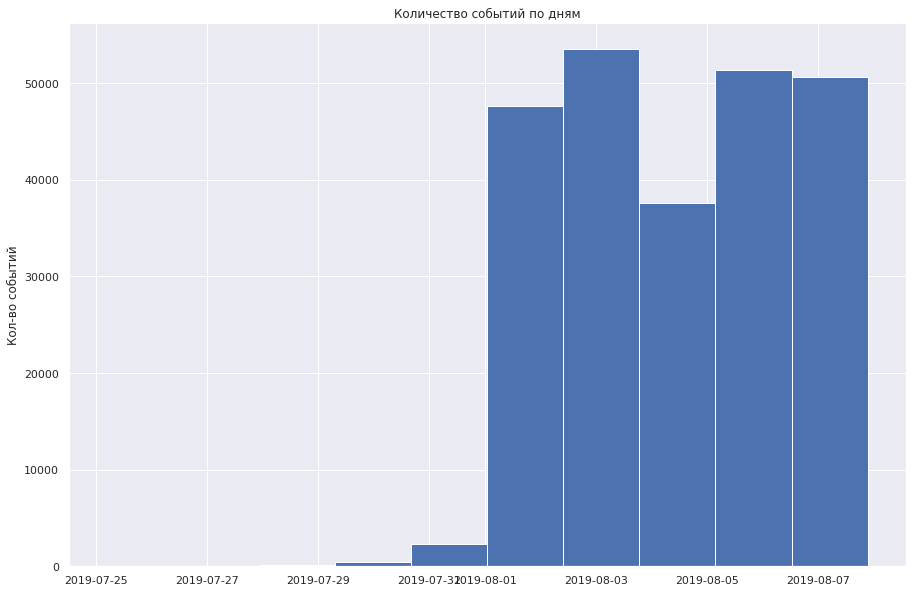

In [23]:
#построила гистограмму по дате и времени
df['event_dt'].hist()
plt.title('Количество событий по дням')
plt.ylabel('Кол-во событий')
plt.show() 

**Вывод: так как события пользователей за предыдущие дни могут "доезжать" при анализе новых дней, то определила временной промежуток с 2019-08-01 по 2019-08-07**

In [24]:
#сформировала датафрейм с актуальным временным горизонтом
df_new=df.query('event_dt >= "2019-08-01"')

In [25]:
#проверила много ли событий потеряла, отбросив старые данные
df_new['event_name'].count()

240887

In [26]:
#посчитала кол-во потерянных событий
loss_event=(df['event_name'].count())-(df_new['event_name'].count())
print('Кол-во потерянных событий:', loss_event)

Кол-во потерянных событий: 2826


In [27]:
#посчитала долю потерянных событий
print('Доля потерянных событий:', round((loss_event/df['event_name'].count())*100, 2), '%')

Доля потерянных событий: 1.16 %


**Вывод: после отсечения событий осталось 240887 (ранее 243713), потеря - 2826, ушло менее - 2% (1,16%), не критично**

In [28]:
#проверила много ли пользователей потеряла, отбросив старые данные
df_user_total=df_new['user_id'].nunique()

In [29]:
#посчитала кол-во потерянных пользователей
loss_user=(df['user_id'].nunique())-(df_new['user_id'].nunique())
print('Кол-во потерянных пользователей:', loss_user)

Кол-во потерянных пользователей: 17


In [30]:
#посчитала долю потерянных пользователей
print('Доля потерянных пользователей:', round((loss_user/df['user_id'].nunique())*100, 2), '%')

Доля потерянных пользователей: 0.23 %


**Вывод: после отсечения пользователей осталось 7534 (ранее 7551), потеря - 17, ушло менее 1% (0,23%), не критично**

In [31]:
#проверила, что есть пользователи из всех трёх экспериментальных групп и соотношение кол-ва клиентов между группами
df_new.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


**Вывод: после отсечения все три экспериментальные группы присутствуют и разница между группами в рамках кол-ва незначительная**

**Шаг 4. Изучите воронку событий**

In [32]:
#посмотрела, какие события есть в логах, как часто они встречаются
df_new.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


**Вывод: больше всего произошло событий MainScreenAppear (главная страница), составляет почти 50% от всего кол-ва. Далее идут OffersScreenAppear (предложения), CartScreenAppear (корзина) и PaymentScreenSuccessful (оплата), и в аутсайдерах (прочитали руководство) - Tutorial. Это естественное распределение воронки**

In [33]:
#посчитала, сколько пользователей совершали каждое из этих событий
df_count_user_id=df_new.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
df_count_user_id

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


**Вывод: аналогичный предыдущему**

In [34]:
#посчитала долю пользователей, которые хоть раз совершали событие
df_count_user_id['event_user_total_pr'] = round((df_count_user_id['user_id']/df_user_total)*100, 2)
df_count_user_id

,event_name,user_id,event_user_total_pr
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


**Вывод: tutorial в принципе можно исключить, так как не показательное событие. А так результаты не плохие, от всех уникальных пользователей к оплате переходит 47%**

In [35]:
#посчитала по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)
df_count_user_id['event_user_pr']=round((df_count_user_id['user_id']/df_count_user_id['user_id'].shift(1, fill_value=0))*100, 2)
df_count_user_id

,event_name,user_id,event_user_total_pr,event_user_pr
0,MainScreenAppear,7419,98.47,inf
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78
4,Tutorial,840,11.15,23.74


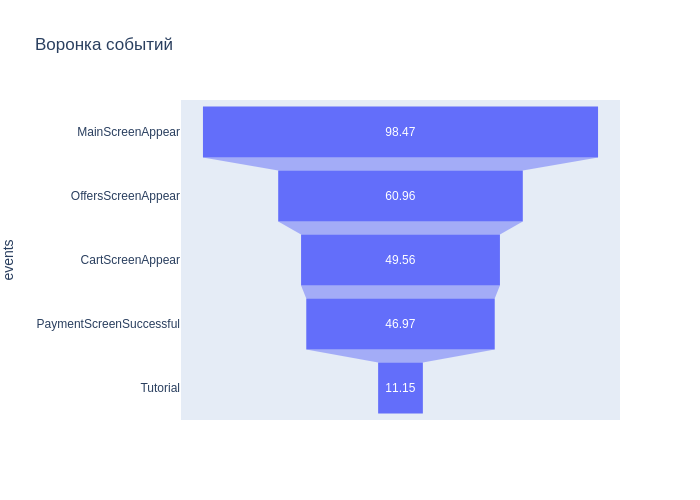

In [36]:
#построила график воронки событий по пользователям
fig = go.Figure(go.Funnel(x = df_count_user_id['event_user_total_pr'], y = df_count_user_id['event_name']))
fig.update_layout (title='Воронка событий',
           yaxis_title='events')
fig.show()

**Вывод: как писала ранее tutorial не показательное событие. Если смотреть на воронку событий, то для меня самое узкое место - это переход из предложений в корзину (переходят всего лишь 49% от всего потока), на втором месте переход из главной страницы на страницу предложений (37%)**

**Шаг 5. Изучите результаты эксперимента**

**Проверка гипотез**.

**Нулевая гипотеза: нет оснований считать доли разным. Альтернативная гипотеза: между долями есть значимая разница**

In [37]:
#проверила статистические критерии разницу между выборками 246 и 247 с помощью функции
users_total=df.groupby('group')['user_id'].nunique()
users_total['246_247']=users_total[246]+users_total[247]

users_funnel=(
    df_new.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .reset_index()
    .sort_values(by=246, ascending=False)
)
users_funnel['246_247']=users_funnel[246] + users_funnel[247]

def  z_test_check (group1, group2, alpha):
    for i in users_funnel.index: 
        p1=users_funnel[group1][i]/users_total[group1]
        p2=users_funnel[ group2][i]/users_total[group2]
        p_combined=((users_funnel[group1][i]+users_funnel[group2][i])/(users_total[group1]+users_total[group2]))
        difference=p1-p2
        z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/users_total[group1]+1/users_total[group2]))
        distr=stats.norm(0, 1)
        p_value=(1-distr.cdf(abs(z_value)))*2 
        print ('{}p-значение:{}'.format(users_funnel['event_name'][i], p_value)) 
        if (p_value<alpha ): 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница') 
        else: 
            print('Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    
z_test_check(246, 247, 0.5)

MainScreenAppearp-значение:0.6194860229779078
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.2352227460362717
Отвергаем нулевую гипотезу: между долями есть значимая разница
CartScreenAppearp-значение:0.21899829728450415
Отвергаем нулевую гипотезу: между долями есть значимая разница
PaymentScreenSuccessfulp-значение:0.10914759823712927
Отвергаем нулевую гипотезу: между долями есть значимая разница
Tutorialp-значение:0.9454168827071352
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод: статистической разницы между группами A/A - нет, говорит о том, что группы подобраны верно, а также, что общий вывод вызывает больше доверия**

In [38]:
#проверила статистические критерии разницу между выборками 246 и 248
z_test_check(246, 248, 0.1)

MainScreenAppearp-значение:0.32916112087956995
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.2097513010649208
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppearp-значение:0.07897406022802644
Отвергаем нулевую гипотезу: между долями есть значимая разница
PaymentScreenSuccessfulp-значение:0.21318312148591856
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Tutorialp-значение:0.8268596773192287
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
#проверила статистические критерии разницу между выборками 247 и 248
z_test_check(247, 248, 0.05)

MainScreenAppearp-значение:0.630511483398956
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.948242051780652
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppearp-значение:0.598491352466854
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessfulp-значение:0.7174796792830545
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Tutorialp-значение:0.7731671969169724
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
#проверила статистические критерии разницу между выборками 246+247 и 248
z_test_check('246_247', 248, 0.05)

MainScreenAppearp-значение:0.39650789406907316
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppearp-значение:0.44807592847340594
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppearp-значение:0.18799753938915797
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessfulp-значение:0.6123472065065059
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Tutorialp-значение:0.7696461997168715
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Итоговый вывод:**

**Для корректного анализа на этапе предобработки данных переименовала наименование столбцов, добавила столбец дат для использования в дальнейшей аналитике, проверила на пропуски методом info, удалила явные дубликаты, проверила на аномальные/отрицательные/нулевые значения методом describe (не выявлено), а также проверила соотношение кол-ва клиентов между группами (незначительные отклонения) и на наличие клиентов в двух и более группах одновременно (отсутствуют). Далее определила горизонт анализа и проверила результаты тестирования. Данная работа позволила принять правильное решение: остановить тест, изменение шрифта не повлияют на конверсию и увеличение продаж.**

**А также позволила сформировать рекомендации по дальнейшем работам, а именно стоит провести анализ на рекламные компании, на существующие предложения для клиентов, проверить функциональность приложения и вообще взглянуть на юзабилти, так как значительное кол-во клиентов (50%) теряются на этапе перехода из предложений в корзину.**

**Факты:**

В процессе тестирования было проведено 20 экспериментов, которые не показали статистическoй разницы между выборками:

246/247 - 5 эксперементов (для каждого события) / уровень статистической чувствительности - 5%

246/248 - 5 экспериментов (для каждого события) / уровень статистической чувствительности - 5%

247/248 - 5 экспериментов (для каждого события) / уровень статистической чувствительности - 5%

246+247/248 - 5 эксперементов (для каждого события) / уровня статистической чувствительности - 5%